In [1]:
%matplotlib inline

import logging

import matplotlib.pyplot as plt
import numpy as np

from dynrat import set_logging_level


# loggin levels include
#   'error'
#   'warning'
#   'info'
#   'debug'

set_logging_level('warning')

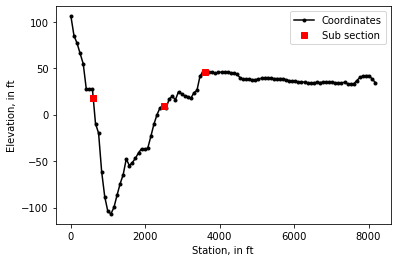

In [2]:
from anchovy.crosssection import CrossSection
from dynrat.sect import CrossSect


xs_csv = 'data/vbms/site_07289000_cs_20110517.csv'

station, elevation = np.loadtxt(xs_csv, delimiter=',', skiprows=1, unpack=True)

roughness = [0.060, 0.040, 0.050, 0.040]
sect_stat = [600, 2500, 3600]
xs = CrossSection(station, elevation, roughness, sect_stat, True)
sect = CrossSect(xs)
_ = xs.plot()

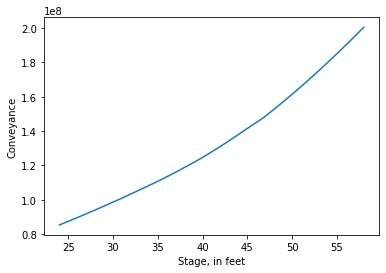

In [3]:
stage = np.linspace(24, 58)
conveyance = xs.conveyance(stage)
_ = plt.plot(stage, conveyance)
_ = plt.xlabel('Stage, in feet')
_ = plt.ylabel('Conveyance')

0

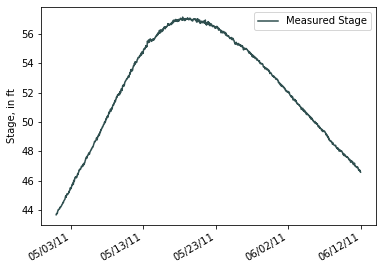

In [4]:
from dynrat.timeseries import MeasuredStageTimeSeries


event_start_date = '5/1/2011 00:00'
event_end_date = '6/12/2011 00:00'

aq_stage_csv = 'data/vbms/site_07289000_iv_s_Aquarius.csv'
measured_stage = MeasuredStageTimeSeries.from_aq_csv(aq_stage_csv, interp_missing=True)
measured_stage = measured_stage.subset_dt(event_start_date, event_end_date)

_ = measured_stage.plot()

measured_stage.null_obs()

0

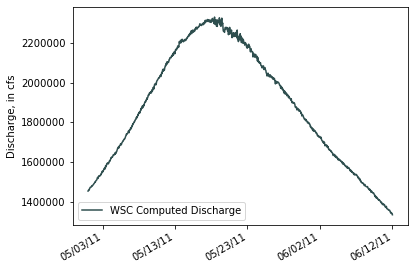

In [5]:
from dynrat.timeseries import RatedDischargeTimeSeries


aq_flow_csv = 'data/vbms/site_07289000_iv_q_Aquarius.csv'
rated_flow = RatedDischargeTimeSeries.from_aq_csv(aq_flow_csv, interp_missing=True)
rated_flow = rated_flow.subset_dt(event_start_date, event_end_date)
_ = rated_flow.plot()

rated_flow.null_obs()

In [6]:
from dynrat.rslope import r_slope


h_o = 23.00  # stage prior to start of typical flood
h_p = 36.72  # peak stage of typical flood
q_o = 625000  # flow prior to typical flood
q_p = 1050000  # peak flow of typical flood
t_diff = 21  # elapsed time of stage rise to peak stage in days

bed_slope = 0.00011

slope_ratio = r_slope(h_o, h_p, q_o, q_p, bed_slope, sect, t_diff)
slope_ratio

101.46879798925792

In [7]:
from dynrat.timeseries import read_nwis_rdb


fm_rdb_path = 'data/vbms/site_07289000_fm_NWIS.txt'
observed_stage, observed_flow = read_nwis_rdb(fm_rdb_path)

observed_stage = observed_stage.subset_dt(event_start_date, event_end_date)
observed_flow = observed_flow.subset_dt(event_start_date, event_end_date)

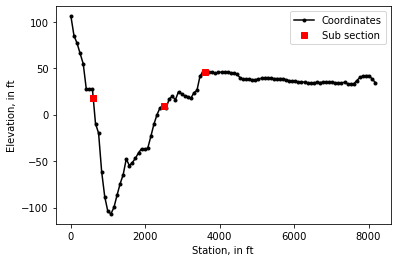

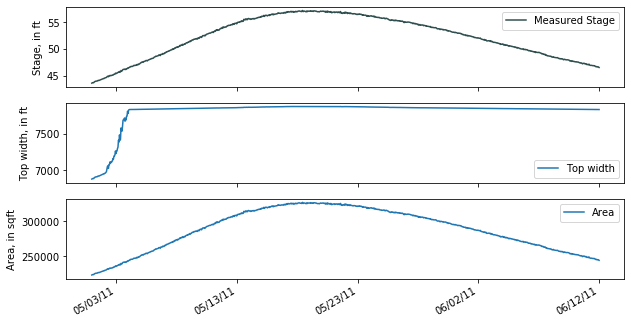

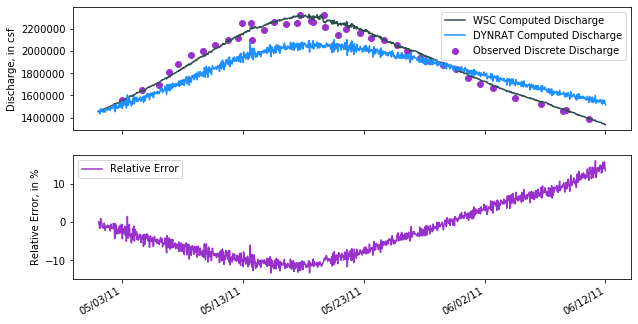

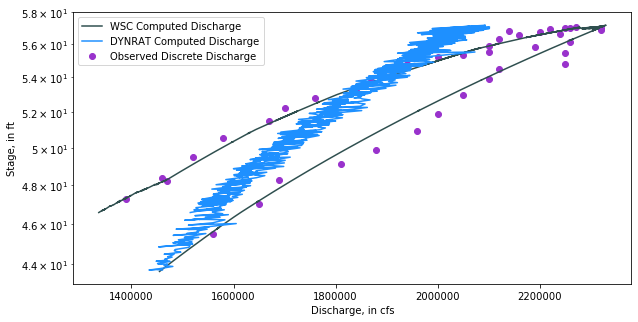

In [8]:
from dynrat.dynpound import QSolver
from dynrat.solve import QTimeSeries
from dynrat.plot import stage_discharge_plot


h0 = measured_stage.values()[0]
h1 = measured_stage.values()[1]
q0 = rated_flow.values()[0]
q1 = rated_flow.values()[1]

time_step = measured_stage.freq()

_ = xs.plot()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(10, 5))

_ = measured_stage.plot(ax1)

_ = measured_stage.cross_section_plot(sect, 'top width', ax=ax2)
_ = ax2.set_ylabel('Top width, in ft')
_ = ax2.set_xlabel('')

_ = measured_stage.cross_section_plot(sect, 'area', ax=ax3)
_ = ax3.set_ylabel('Area, in sqft')

solver = QSolver(sect, bed_slope, slope_ratio, time_step)

qts = QTimeSeries(solver)
computed_flow = qts.solve_ts(measured_stage, q0)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 5))

_ = rated_flow.plot(ax1)
_ = observed_flow.plot(ax1)
_ = computed_flow.plot(ax1)

_ = computed_flow.plot_relative_error(rated_flow, ax2)

fig, ax = plt.subplots(figsize=(10, 5))
_ = stage_discharge_plot(measured_stage, rated_flow, ax)
_ = stage_discharge_plot(observed_stage, observed_flow, ax)
_ = stage_discharge_plot(measured_stage, computed_flow, ax, color='dodgerblue', label='DYNRAT Computed Discharge')